Выходные данные были обрезаны до нескольких последних строк (5000).
Cycle 2: Best Fitness = 7490.607112283174
Cycle 3: Best Fitness = 7486.842630562334
Cycle 4: Best Fitness = 7485.156041156425
Cycle 5: Best Fitness = 7462.440952145267
Cycle 6: Best Fitness = 7448.8780886679215
Cycle 7: Best Fitness = 7431.738996051663
Cycle 8: Best Fitness = 7423.25592932245
Cycle 9: Best Fitness = 7423.25592932245
Cycle 10: Best Fitness = 7423.25592932245
Cycle 11: Best Fitness = 7423.25592932245
Cycle 12: Best Fitness = 7423.25592932245
Cycle 13: Best Fitness = 7422.315775999856
Cycle 14: Best Fitness = 7417.735637017277
Cycle 15: Best Fitness = 7399.220164865745
Cycle 16: Best Fitness = 7379.245044062713
Cycle 17: Best Fitness = 7350.513804647473
Cycle 18: Best Fitness = 7325.9111049485655
Cycle 19: Best Fitness = 7306.8612293274455
Cycle 20: Best Fitness = 7305.315849972884
Cycle 21: Best Fitness = 7305.315849972884
Cycle 22: Best Fitness = 7297.478958441434
Cycle 23: Best Fitness = 7297.478958441

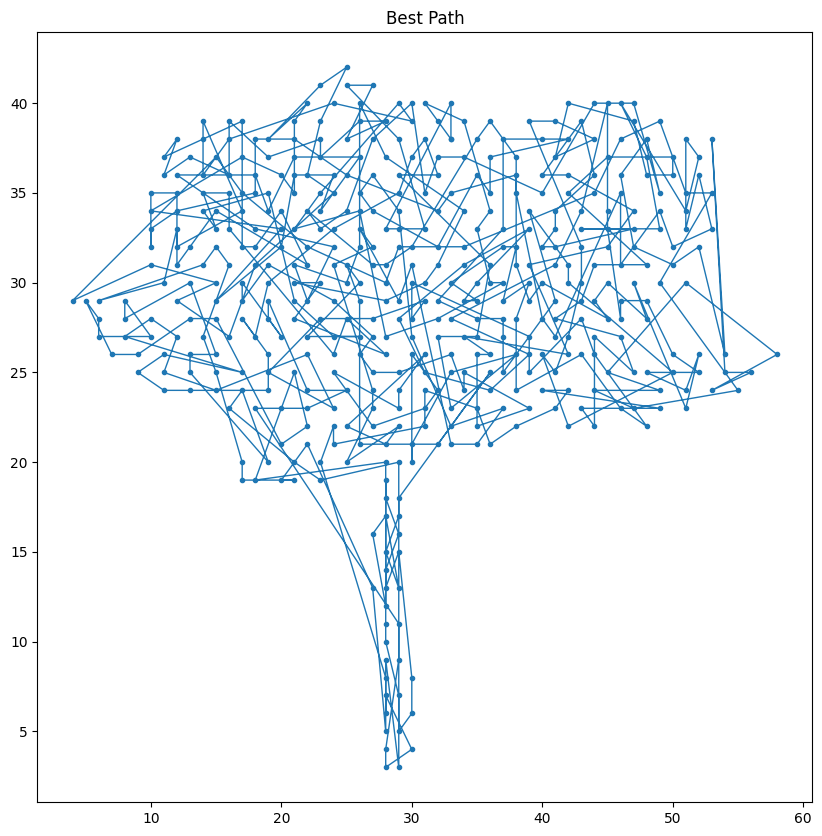

Execution Time: 144.52 seconds


In [2]:
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import time

class DitheringMaker:
    '''
    Performs dithering on an image using the classical Floyd-Steinberg dithering algorithm. The
    dithering isn't applied to the last row or the edge columns. Instead the last row and edge
    columns are made all white as this will later not add any vertices when we extract vertices
    from the dithering.

    Members
    -------
    dithering : Numpy array of Int of Shape(n_rows, nCol)
        The array holding the dithering of the image. Note that the last row and edge columns will
        always be converted to white (i.e. 255).

    row_disp : Numpy array of Int of shape (2, 3)
        The row offsets to apply the diffusions to.

    col_disp : Numpy array of Int of shape (2, 3)
        The column offsets to apply the diffusions to.

    diffusion_prop : Numpy array of Float of shape (2, 3)
        The Floyd-Steinberg coefficients for diffusing the error in the
        dithering.
    '''

    def __init__(self):
        '''
        Initialize the dithering to None as we haven't performed any yet.

        The displacement of indices and the diffusion coefficients are for the classic
        Floyd-Steinberg dithering algorithm.
        '''

        self.dithering = None

        self.row_disp = np.full((2, 3), np.arange(0, 2)[:, np.newaxis], dtype = 'int')
        self.col_disp = np.full((2, 3), np.arange(-1, 2), dtype = 'int')
        self.diffusion_prop = np.array([[0, 0, 7],
                                        [3, 5, 1]]) / 16

    def make_dithering(self, pixels, cutoff = 255 / 2):
        '''
        Apply the classic Floyd-Steinberg dithering algorithm, but for simplicity
        we just make the edge columns and the last row all white (which will give
        us no vertices when we later extract vertices).

        Parameters
        ----------
        pixels : Numpy array of Int of shape (n_rows, n_cols)
            The gray scale pixels to apply the dithering to.

        cutoff : Float
            The cut off for making a dithering pixel either 0 or 255.

        Returns
        -------
        Numpy array of Int of Shape (n_rows, n_cols)
            The final dithering; each pixel is either 0 or 255 (black or white).
        '''

        # We use Floyd-Steinberg dithering. Error diffusion is
        # _     x     7/16
        # 3/16  5/16  1/16

        self.dithering = pixels.copy().astype('float')

        n_rows, n_cols = pixels.shape

        # Initialize the first column to be white.

        self.dithering[:][0] = 255

        # Iterate over each row, applying the dithering and diffusing the error.

        for row in range(n_rows - 1):
            for col in range(1, n_cols - 1):

                dither, error = self.get_dither(row, col, cutoff)
                self.dithering[row, col] = dither
                self.diffuse_error(error, row, col)

        # Make the last column and the last row all white.

        self.dithering[:, -1] = 255
        self.dithering[-1, :] = 255


        # Convert dithering to Numpy array of Int.

        self.dithering = self.dithering.astype('int')

        return self.dithering

    def get_dither(self, row, col, cutoff):
        '''
        Turn (dithered) pixel into either 0 or 255 using cutoff.

        Parameters
        ----------
        row : Int
            Index of pixel row.

        col : Int
            Index of pixel column.

        cutoff : Float
            The cutoff value to use for converting dithering value to either 0 or 255
            (black or white).

        Returns
        -------
        dither : Float
            Floating point value that is either 0.0 or 255.0 (black or white).

        error : Float
            The error in applying the conversion, this needs to be diffused to other pixels
            according to the dithering algorithm.
        '''

        pixel = self.dithering[row][col]

        if pixel < cutoff:
            dither = 0.0
        else:
            dither = 255.0

        error = pixel - dither

        return dither, error

    def diffuse_error(self, error, row, col):
        '''
        Diffuse the error from a (dithered) pixel conversion to black or white. The diffusion
        is applied to the neighbors of the pixel at position [row, col] according to the
        Floyd-Steinberg algorithm.

        Parameters
        ----------
        error : Float
            The size of error to diffuse to other pixels.

        row : Int
            The row index of where the conversion took place.

        col : Int
            The column index of where the conversion took place.
        '''

        self.dithering[row + self.row_disp, col + self.col_disp] += error * self.diffusion_prop

def get_vertices(dithering):
    '''
    Get the vertices from a black and white image, not grayscale (in particular a dithered image).
    Every black pixel (value 0.0) gives a vertex.

    Parameters
    ----------
    dithering : Numpy array of shape (n_rows, n_cols)
        The array of pixels for the dithered image.

    Returns
    -------
    Numpy array of shape (nVertices, 2)
        The xy-coordinates of the vertices.
    '''

    n_rows, n_cols = dithering.shape

    # Each black pixel gives a vertex.
    keep_pixel_mask = (dithering == 0)

    # Get the row and column indices of the vertices.

    rows = np.full(dithering.shape, np.arange(n_rows)[:, np.newaxis]).reshape(-1)
    cols = np.full(dithering.shape, np.arange(n_cols)).reshape(-1)

    rows = rows[keep_pixel_mask.reshape(-1)]
    cols = cols[keep_pixel_mask.reshape(-1)]

    # Get the xy-coordinate of the vertices. Make sure to transform row index so
    # that the last row has y value 0.

    vertices = np.stack([cols, n_rows - rows], axis = -1)

    return vertices


def getPixels(image, ds=1):
    '''
    Get the pixels as a numpy array from a PIL image.
    We can take the mean of each ds x ds subsquare as an array element inorder to down-size
    the size of the image if we want to.

    Parameters
    ----------
    image : PIL Image
        The PIL image to convert.

    ds : Int
        We take the mean of each ds x ds sub-square for a single element of our array.

    Returns
    -------
    2d Numpy array of floats
        The converted values of the pixels in the image. We use mean because we
        possibly took a mean over sub-squares.
    '''
    imwidth, imheight = image.size
    pixels = list(image.getdata())
    pixels = np.array(pixels).reshape((imheight, imwidth))
    pixels = [[pixels[i:i + ds, j:j + ds].mean() for j in np.arange(0, imwidth, ds)]
              for i in np.arange(0, imheight, ds)]
    return np.array(pixels)

class TSP_ABC:
    def __init__(self, image_path, num_bees=100, max_cycles=100):
        self.image_path = image_path
        self.num_bees = num_bees
        self.max_cycles = max_cycles

    def process_image(self):
        image = Image.open(self.image_path).convert('L')
        pixels = getPixels(image, ds=5)
        ditherer = DitheringMaker()
        self.dithered_image = ditherer.make_dithering(pixels)
        self.vertices = get_vertices(self.dithered_image)
        self.distance_matrix = self.calculate_distance_matrix(self.vertices)

    def calculate_distance_matrix(self, vertices):
        diff = np.expand_dims(vertices, axis=1) - np.expand_dims(vertices, axis=0)
        return np.sqrt((diff ** 2).sum(axis=2))

    def fitness(self, tour):
        return np.sum(self.distance_matrix[np.roll(tour, 1), tour])

    def initialize_population(self):
        population = []
        for _ in range(self.num_bees):
            tour = np.random.permutation(len(self.vertices))
            population.append(tour)
        return population

    def two_opt_swap(self, tour):
        i, j = sorted(random.sample(range(len(tour)), 2))
        tour[i:j+1] = tour[i:j+1][::-1]
        return tour

    def select_solution(self, current_solution, candidate_solution):
        if self.fitness(candidate_solution) < self.fitness(current_solution):
            return candidate_solution
        return current_solution

    def abc_algorithm(self):
        population = self.initialize_population()
        fitnesses = [self.fitness(ind) for ind in population]
        best_fitness = float('inf')
        best_solution = None

        non_improving_cycles = 0
        max_non_improving_cycles = 30

        for cycle in range(self.max_cycles):
            # Employed Bee Phase
            for i in range(self.num_bees):
                candidate_solution = self.two_opt_swap(population[i].copy())
                population[i] = self.select_solution(population[i], candidate_solution)
                fitnesses[i] = self.fitness(population[i])

            # Onlooker Bee Phase
            max_fitness = max(fitnesses)
            probabilities = [(max_fitness - f + 1) / sum(max_fitness - np.array(fitnesses) + 1) for f in fitnesses]
            for _ in range(self.num_bees):
                selected_index = np.random.choice(self.num_bees, p=probabilities)
                candidate_solution = self.two_opt_swap(population[selected_index].copy())
                new_solution = self.select_solution(population[selected_index], candidate_solution)
                new_fitness = self.fitness(new_solution)
                if new_fitness < fitnesses[selected_index]:
                    population[selected_index] = new_solution
                    fitnesses[selected_index] = new_fitness

            # Scout Bee Phase
            if non_improving_cycles >= max_non_improving_cycles:
                for i in range(self.num_bees // 10):
                    idx = random.randint(0, self.num_bees - 1)
                    population[idx] = np.random.permutation(len(self.vertices))
                    fitnesses[idx] = self.fitness(population[idx])
                non_improving_cycles = 0

            current_best_idx = np.argmin(fitnesses)
            if fitnesses[current_best_idx] < best_fitness:
                best_fitness = fitnesses[current_best_idx]
                best_solution = population[current_best_idx]
                non_improving_cycles = 0
            else:
                non_improving_cycles += 1

            print(f"Cycle {cycle + 1}: Best Fitness = {best_fitness}")

        return best_solution, best_fitness

    def plot_path(self, best_solution):
        '''
        Plot the best path found by the solver.
        '''
        best_path = [self.vertices[i] for i in best_solution] + [self.vertices[best_solution[0]]]
        x, y = zip(*best_path)
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, '-o', markersize=3, linewidth=1)
        plt.title("Best Path")
        plt.show()

    def solve(self):
        '''
        Solver
        '''
        start_time = time.time()
        self.process_image()
        best_solution, best_fitness = self.abc_algorithm()
        end_time = time.time()
        exec_time = end_time - start_time
        print("Best solution:", best_fitness)
        self.plot_path(best_solution)
        print(f"Execution Time: {exec_time:.2f} seconds")

if __name__ == "__main__":
    solver = TSP_ABC("flower.png", num_bees=100, max_cycles=5000)
    solver.solve()